In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [142]:
df=pd.read_csv('../csv/dataset_ml.csv')

In [143]:
df=df.drop(['id_advert','city'],axis=1)

In [144]:
# Séparer les variables indépendantes (X) de la variable cible (y)
X = df.drop("scam", axis=1)
y = df["scam"]

In [145]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [146]:
# Définir les colonnes nécessitant une normalisation
numerical_cols = ['size','price','other_campus_dressing','other_campus_sell','hype_products_dressing',
                 'hype_products_sell','item_count','total_items_count','given_item_count','taken_item_count',
                 'feedback_reputation','followers_count','following_count']
binary_categorical_cols = ['price_decimal','ressell_price','promoted','identic_title_description','short_description',
                      'secure_description','has_emoji_description','description_user','sell_sneaker_account','photo',
                      'is_publish_photos_agreed','expose_location','verification_facebook','verification_google','verification_phone'] 
other_categorical_cols = ['gender','brand','country_title','modele']

In [147]:
# Définir les transformations pour les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normaliser les variables numériques
        ('bin_cat', 'passthrough', binary_categorical_cols),  # Ne rien faire pour les colonnes binaires
        ('other_cat', OneHotEncoder(handle_unknown='ignore'), other_categorical_cols)  # Appliquer OneHotEncoder aux autres colonnes catégorielles
    ])

## Baseline Model : XGBoost

In [148]:
# Créer le pipeline avec le préprocesseur et le modèle RandomForest
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

In [149]:
# Entraîner le modèle
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['size', 'price',
                                                   'other_campus_dressing',
                                                   'other_campus_sell',
                                                   'hype_products_dressing',
                                                   'hype_products_sell',
                                                   'item_count',
                                                   'total_items_count',
                                                   'given_item_count',
                                                   'taken_item_count',
                                                   'feedback_reputation',
                                                   'followers_count',
                                                   'following_count']),
                                                 ('bin_cat', 'passthrough',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [150]:
# Prédire sur l'ensemble d'entraînement
y_train_pred = pipeline_xgb.predict(X_train)

# Prédire sur l'ensemble de test
y_test_pred = pipeline_xgb.predict(X_test)

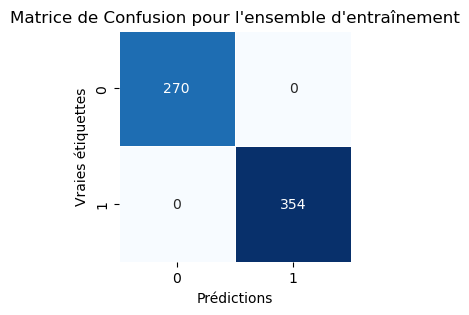

In [151]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_train, y_train_pred)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble d\'entraînement')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [152]:
# Afficher les métriques de classification pour l'ensemble d'entraînement
print("Métriques pour l'ensemble d'entraînement:")
print(classification_report(y_train, y_train_pred))

Métriques pour l'ensemble d'entraînement:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       270
           1       1.00      1.00      1.00       354

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624



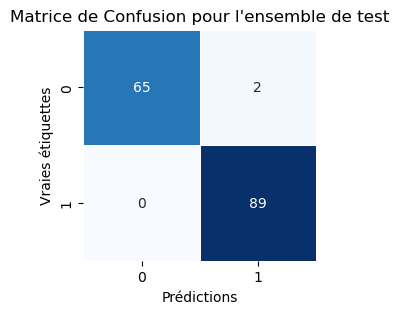

In [153]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble de test')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [154]:
# Afficher les métriques de classification pour l'ensemble de test
print("Métriques pour l'ensemble de test:")
print(classification_report(y_test, y_test_pred))

Métriques pour l'ensemble de test:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        67
           1       0.98      1.00      0.99        89

    accuracy                           0.99       156
   macro avg       0.99      0.99      0.99       156
weighted avg       0.99      0.99      0.99       156



In [155]:
# erreur de prédictions
incorrect_predictions = X_test[y_test != y_test_pred]
incorrect_predictions

,modele,size,brand,price,price_decimal,ressell_price,promoted,identic_title_description,short_description,secure_description,...,followers_count,following_count,gender,photo,is_publish_photos_agreed,expose_location,country_title,verification_facebook,verification_google,verification_phone
157,orange,43.0,adidas,80.0,0,150,0,0,0,1,...,2,0,not_specified,1,0,1,France,0,1,1
462,green_black,37.5,adidas,83.0,0,110,0,0,0,0,...,4,0,not_specified,1,0,1,France,0,1,1


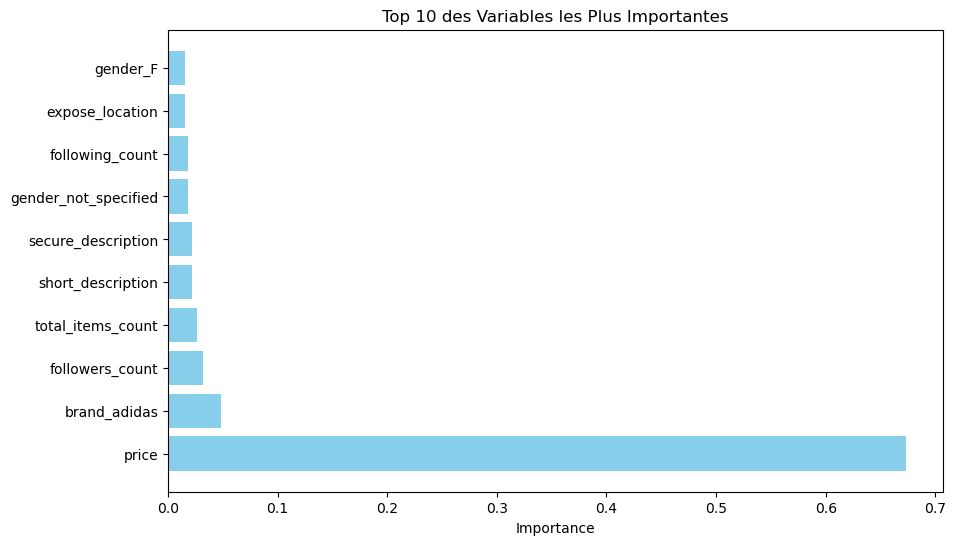

In [156]:
# feature importance
xgb_model = pipeline_xgb.named_steps['classifier']

importances = xgb_model.feature_importances_
preprocessed_columns = numerical_cols + binary_categorical_cols + list(pipeline_xgb.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out(other_categorical_cols))


feature_importances = pd.DataFrame({'Variable': preprocessed_columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Variable'][:10], feature_importances['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 des Variables les Plus Importantes')
plt.show()

## Optimisation

In [157]:
# Créer le pipeline avec le préprocesseur et le modèle RandomForest
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

In [158]:
# Définition des paramètres de la grille
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__n_estimators': [50, 100, 200],
}

In [159]:
#Utilisation du gridSearchCV
grid_search = GridSearchCV(pipeline_xgb, param_grid, scoring='f1', cv=5)

In [160]:
#Entraînement du modèle
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['size',
                                                                          'price',
                                                                          'other_campus_dressing',
                                                                          'other_campus_sell',
                                                                          'hype_products_dressing',
                                                                          'hype_products_sell',
                                                                          'item_count',
                                                                          'total_items_count',
                                                                          'given_item_count',
                                                                          'taken_item_count',
                                                                          'feedback_reputation',
                                                                          'followers_count',
                                                                          'following_count'...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='f1')

In [161]:
# Meilleurs paramètres
best_model = grid_search.best_estimator_
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

Meilleurs paramètres trouvés :  {'classifier__max_depth': 3, 'classifier__n_estimators': 50}


In [162]:
# Prédire sur l'ensemble d'entraînement
y_train_pred_best = best_model.predict(X_train)

# Prédire sur l'ensemble de test
y_test_pred_best = best_model.predict(X_test)

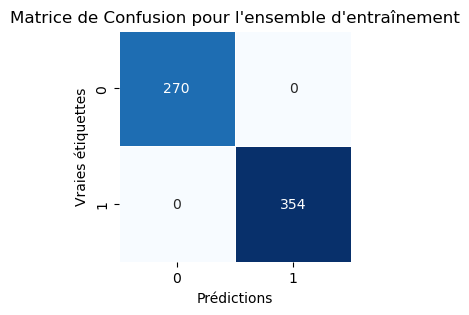

In [163]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_train, y_train_pred_best)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble d\'entraînement')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [164]:
# Afficher les métriques de classification pour l'ensemble d'entraînement
print("Métriques pour l'ensemble d'entraînement:")
print(classification_report(y_train, y_train_pred_best))

Métriques pour l'ensemble d'entraînement:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       270
           1       1.00      1.00      1.00       354

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624



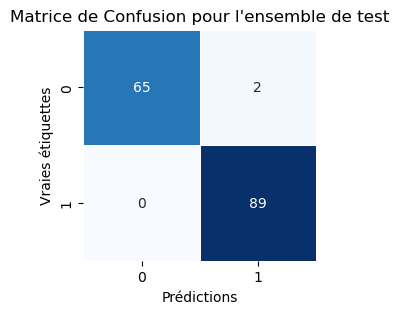

In [165]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred_best)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble de test')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [166]:
# Afficher les métriques de classification pour l'ensemble de test
print("Métriques pour l'ensemble de test:")
print(classification_report(y_test, y_test_pred_best))

Métriques pour l'ensemble de test:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        67
           1       0.98      1.00      0.99        89

    accuracy                           0.99       156
   macro avg       0.99      0.99      0.99       156
weighted avg       0.99      0.99      0.99       156



In [167]:
# lignes avec des erreurs
incorrect_predictions = X_test[y_test != y_test_pred_best]
incorrect_predictions

,modele,size,brand,price,price_decimal,ressell_price,promoted,identic_title_description,short_description,secure_description,...,followers_count,following_count,gender,photo,is_publish_photos_agreed,expose_location,country_title,verification_facebook,verification_google,verification_phone
157,orange,43.0,adidas,80.0,0,150,0,0,0,1,...,2,0,not_specified,1,0,1,France,0,1,1
462,green_black,37.5,adidas,83.0,0,110,0,0,0,0,...,4,0,not_specified,1,0,1,France,0,1,1


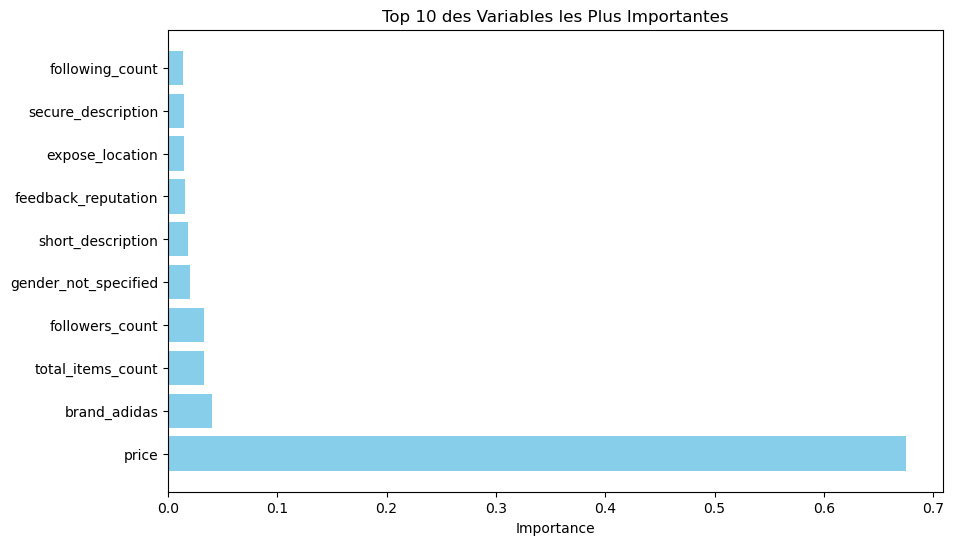

In [168]:
# feature importance
xgb_model = grid_search.best_estimator_['classifier']

importances = xgb_model.feature_importances_
preprocessed_columns = numerical_cols + binary_categorical_cols + list(pipeline_xgb.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out(other_categorical_cols))


feature_importances = pd.DataFrame({'Variable': preprocessed_columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Variable'][:10], feature_importances['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 des Variables les Plus Importantes')
plt.show()